In [ ]:
import numpy as np, pandas as pd, sklearn, os, matplotlib.pyplot as plt, seaborn, plotly, yaml, pyarrow, more_itertools, json, math, textwrap
print("All required packages are already installed!")
os.environ["CUDA_VISIBLE_DEVICES"] = ""


All required packages are already installed!


In [ ]:
# run preprocessing
!python converter.py


In [ ]:
# train the Telemanom model
!python algorithm.py "$(tr -d '\n' < json_files/args_train.json)"


In [ ]:
# test the Telemanom model
!python algorithm.py "$(tr -d '\n' < json_files/args_test.json)"


2025-10-05 16:47:07.116937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759682827.136294    2565 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759682827.144002    2565 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759682827.159285    2565 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759682827.159311    2565 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759682827.159315    2565 computation_placer.cc:177] computation placer alr

In [ ]:
%%writefile make_ts_from_algorithm_output.py
import os
import numpy as np
import pandas as pd

RUNS_DIR = "./runs"

#main output produced by algorithm.py
MAIN_OUT = os.path.join(RUNS_DIR, "errors.csv")
RAW_GUESS = MAIN_OUT.replace(".csv", "-no-threshold.csv")
#renaming the raw errors file for consistency
if os.path.exists(RAW_GUESS):
    os.replace(RAW_GUESS, os.path.join(RUNS_DIR, "errors-no-threshold.csv"))
    print("[OK] Renamed raw errors file to errors-no-threshold.csv")

#load the per-channel binary matrix produced by algorithm.py
bin_mat = pd.read_csv(MAIN_OUT, header=None).values  # shape [T, C]; values {0,1} if threshold_scores=true

#aggregate to 1D binary (max across channels)
agg = (bin_mat.max(axis=1)).astype(np.uint8)

#the standardized ESA/Kaggle output files
np.savetxt(os.path.join(RUNS_DIR, "anomaly_scores_Pruned.ts"),    agg, fmt="%d")
np.savetxt(os.path.join(RUNS_DIR, "anomaly_scores_nonPruned.ts"), agg, fmt="%d")

print(" Saved .ts files to:", RUNS_DIR)
print("  - anomaly_scores_Pruned.ts")
print("  - anomaly_scores_nonPruned.ts")


Overwriting make_ts_from_algorithm_output.py


In [ ]:
!python make_ts_from_algorithm_output.py


[OK] Renamed raw errors file to errors-no-threshold.csv
 Saved .ts files to: /content/drive/MyDrive/telemanom_esa/runs
  - anomaly_scores_Pruned.ts
  - anomaly_scores_nonPruned.ts


In [ ]:
#directions to use later while showing the plots
BASE      = "."
RUNS_DIR  = "./runs"   # where model and outputs are
DATA_DIR  = f"{BASE}/data"                                 # test_te.csv from converter.py here
FIG_DIR   = f"{RUNS_DIR}/figures"
OUT_DIR   = f"{RUNS_DIR}/outputs"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# Common files
TEST_TE_CSV          = f"{DATA_DIR}/test_te.csv"
ERRORS_CSV           = f"{RUNS_DIR}/errors.csv"
RAW_ERRORS_CSV       = f"{RUNS_DIR}/errors-no-threshold.csv"
RECONSTRUCTION_CSV   = f"{RUNS_DIR}/model.keras.reconstruction.csv"
BINARY_NONPRUNED_TS  = f"{RUNS_DIR}/anomaly_scores_nonPruned.ts"
BINARY_PRUNED_TS     = f"{RUNS_DIR}/anomaly_scores_Pruned.ts"

# Channels
CHANNELS = [f"channel_{i}" for i in range(41, 47)]
CHANNEL_NAMES = CHANNELS[:]  # keep a copy


In [ ]:
if not os.path.exists(RAW_ERRORS_CSV):
    raise FileNotFoundError(f"Raw errors not found at {RAW_ERRORS_CSV}. "
                            f"Did your testing step produce 'errors-no-threshold.csv'?")

raw_err = pd.read_csv(RAW_ERRORS_CSV)

# Keep only numeric columns (ignore timestamps etc.)
raw_err = raw_err.select_dtypes(include="number")

#sanity check
print("Raw error shape:", raw_err.shape)
print("Error range:", float(raw_err.to_numpy().min()), "→", float(raw_err.to_numpy().max()))

Raw error shape: (521279, 6)
Error range: 0.0 → 0.0167439417116946


In [ ]:
#Load test set (id + channels)
print("Loading test TE:", TEST_TE_CSV)
test_df = pd.read_csv(TEST_TE_CSV)

# Basic cleanup
test_df.rename(columns=lambda c: c.strip().replace("\ufeff",""), inplace=True)
assert "timestamp" in test_df.columns or "id" in test_df.columns, "Need a timestamp or id column in test_te.csv"

if "id" not in test_df.columns:
    test_df["id"] = np.arange(len(test_df))

# Keep only id + channels for plotting
missing = [c for c in CHANNELS if c not in test_df.columns]
if missing:
    raise ValueError(f"Missing expected channels in test_te.csv: {missing}")

#Force numeric channels
test_df[CHANNELS] = test_df[CHANNELS].apply(pd.to_numeric, errors="coerce")

Loading test TE: /content/telemanom_esa/data/test_te.csv


In [ ]:
#Load reconstructions
recon_df = None
if os.path.exists(RECONSTRUCTION_CSV):
    print("Loading reconstructions:", RECONSTRUCTION_CSV)
    recon_df = pd.read_csv(RECONSTRUCTION_CSV)
    # Try to align on length if needed
    min_len = min(len(test_df), len(recon_df))
    if len(test_df) != len(recon_df):
        print(f"Note: length mismatch test({len(test_df)}) vs recon({len(recon_df)}); trimming to {min_len}")
        test_df  = test_df.iloc[:min_len].reset_index(drop=True)
        recon_df = recon_df.iloc[:min_len].reset_index(drop=True)
else:
    print("No reconstruction file found; will skip the signal vs reconstruction plot.")

Loading reconstructions: /content/drive/MyDrive/telemanom_esa/runs/model.keras.reconstruction.csv


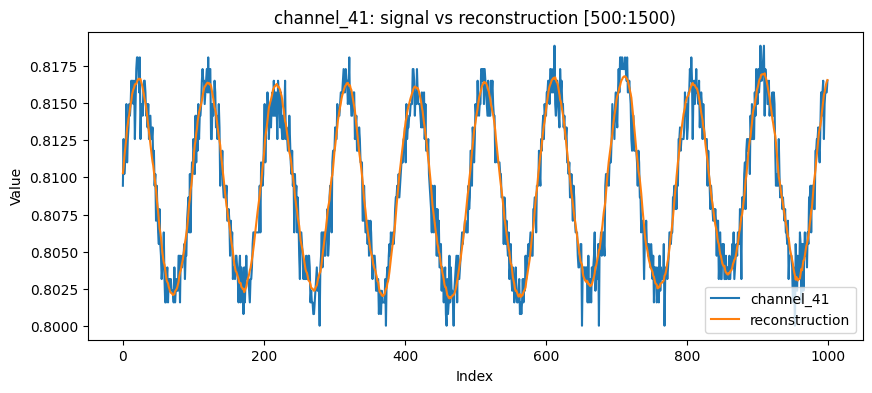

Saved: /content/drive/MyDrive/telemanom_esa/runs/figures/signal_vs_reconstruction_channel_41_500_1500.png


In [ ]:
#Plot: signal vs reconstruction for one channel
def savefig(path):
    plt.tight_layout()
    plt.savefig(path, dpi=150, bbox_inches="tight")
    plt.close()

if recon_df is not None:
    channel_name = CHANNELS[0]  # e.g., "channel_41"
    start_idx, end_idx = 500, 1500
    start_idx = max(0, min(start_idx, len(test_df)-1))
    end_idx   = max(start_idx+1, min(end_idx, len(test_df)))
    seg = pd.DataFrame({
        channel_name: test_df.loc[start_idx:end_idx-1, channel_name].values,
        "reconstruction": recon_df.loc[start_idx:end_idx-1, channel_name].values
    })
    ax = seg.plot(figsize=(10,4), legend=True)  # matplotlib via pandas is fine
    ax.set_title(f"{channel_name}: signal vs reconstruction [{start_idx}:{end_idx})")
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    plt.show()
    savefig(f"{FIG_DIR}/signal_vs_reconstruction_{channel_name}_{start_idx}_{end_idx}.png")
    print("Saved:", f"{FIG_DIR}/signal_vs_reconstruction_{channel_name}_{start_idx}_{end_idx}.png")

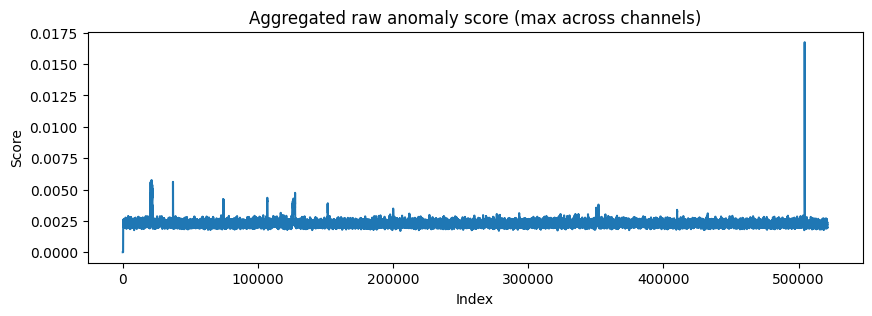

In [ ]:
aggregated_raw = raw_err.max(axis=1)
plt.figure(figsize=(10,3))
plt.plot(aggregated_raw.values)
plt.title("Aggregated raw anomaly score (max across channels)")
plt.xlabel("Index")
plt.ylabel("Score")
plt.show()
savefig(f"{FIG_DIR}/aggregated_raw_scores.png")


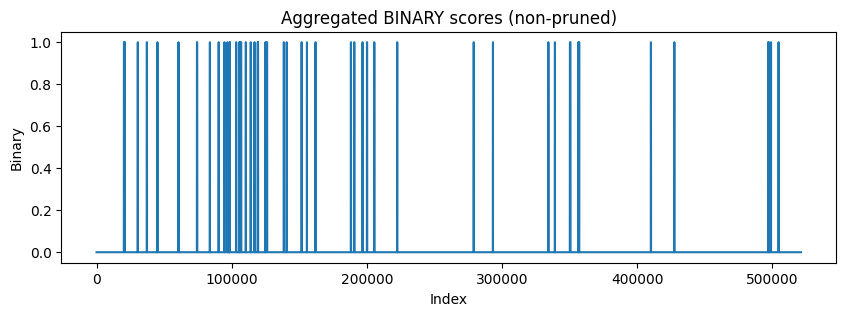

Saved: /content/drive/MyDrive/telemanom_esa/runs/figures/aggregated_binary_nonpruned.png


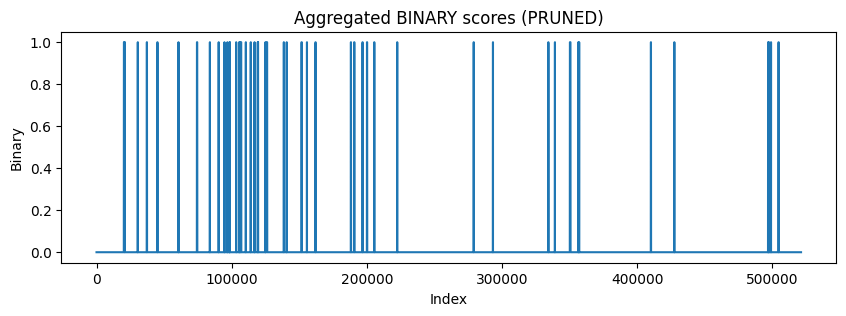

Saved: /content/drive/MyDrive/telemanom_esa/runs/figures/aggregated_binary_pruned.png


In [ ]:
#Load & plot binary scores (we dont have it yet)
def maybe_load_binary(path):
    if os.path.exists(path):
        s = pd.read_csv(path, header=None).squeeze("columns")
        if len(s) != len(test_df):
            print(f"Note: {os.path.basename(path)} length {len(s)} != test length {len(test_df)}; trimming.")
            n = min(len(s), len(test_df))
            s = s.iloc[:n].reset_index(drop=True)
        return s
    return None

binary_nonpruned = maybe_load_binary(BINARY_NONPRUNED_TS)
binary_pruned    = maybe_load_binary(BINARY_PRUNED_TS)

if binary_nonpruned is not None:
    if binary_nonpruned.ndim > 1:
        binary_nonpruned = binary_nonpruned.max(axis=1)
    plt.figure(figsize=(10,3))
    plt.plot(binary_nonpruned.values)
    plt.title("Aggregated BINARY scores (non-pruned)")
    plt.xlabel("Index"); plt.ylabel("Binary")
    plt.show()
    savefig(f"{FIG_DIR}/aggregated_binary_nonpruned.png")
    print("Saved:", f"{FIG_DIR}/aggregated_binary_nonpruned.png")

if binary_pruned is not None:
    if binary_pruned.ndim > 1:
        binary_pruned = binary_pruned.max(axis=1)
    plt.figure(figsize=(10,3))
    plt.plot(binary_pruned.values)
    plt.title("Aggregated BINARY scores (PRUNED)")
    plt.xlabel("Index"); plt.ylabel("Binary")
    plt.show()
    savefig(f"{FIG_DIR}/aggregated_binary_pruned.png")
    print("Saved:", f"{FIG_DIR}/aggregated_binary_pruned.png")


In [ ]:
submissions = []
if binary_pruned is not None:
    submission_df = pd.DataFrame({"id": test_df["id"], "is_anomaly": binary_pruned})
    path = f"{OUT_DIR}/Telemanom-ESA-PRUNED-channels41-46.parquet"
    submission_df.to_parquet(path)
    submission_df.to_csv(f"{OUT_DIR}/submission_pruned.csv", index=False)
    submissions.append(f"{OUT_DIR}/submission_pruned.csv")
    print("Saved submission (pruned):", path)

elif binary_nonpruned is not None:
    submission_df = pd.DataFrame({"id": test_df["id"], "is_anomaly": binary_nonpruned})
    path = f"{OUT_DIR}/Telemanom-ESA-nonPruned-channels41-46.parquet"
    submission_df.to_parquet(path)
    submission_df.to_csv(f"{OUT_DIR}/submission_nonpruned.csv", index=False)
    submissions.append(f"{OUT_DIR}/submission_nonpruned.csv")
    print("Saved submission (non-pruned):", path)

else:
    tmp = pd.DataFrame({"id": test_df["id"], "aggregated_raw": aggregated_raw})
    tmp.to_csv(f"{OUT_DIR}/aggregated_raw_scores.csv", index=False)
    print("No binary files found; wrote aggregated raw scores CSV for inspection.")

print("\nDone. Figures in:", FIG_DIR)
print("Outputs in:", OUT_DIR)

Saved submission (pruned): /content/drive/MyDrive/telemanom_esa/runs/outputs/Telemanom-ESA-PRUNED-channels41-46.parquet

Done. Figures in: /content/drive/MyDrive/telemanom_esa/runs/figures
Outputs in: /content/drive/MyDrive/telemanom_esa/runs/outputs
